In [47]:
# Non-Economic Losses Analysis - Setup
import os
import json
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Plotting style
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.frameon": False,
})

# Constants
INPUT_CSV = "/Users/zhangruotian/Documents/apify_scraper/analysis/merged_all_flood_data.csv"
LOSS = [
    "displacement","education_disruption","health_trauma","social_ties_loss",
    "cultural_ritual_disruption","caregiving_burden","water_food_insecurity",
    "infrastructure_access","psychosocial_distress"
]
PRESENT = [f"loss_{k}_present" for k in LOSS]
CONF = [f"loss_{k}_confidence" for k in LOSS]

# Depth and crowd categorical orders
DEPTH_ORDER = ["none","ankle","knee","waist","vehicle_height","indoor_flood","unknown"]
CROWD_ORDER = ["1","2-5","6-20",">20","unknown"]

print("✅ Setup complete.")


✅ Setup complete.


In [48]:
# Load data and unify timestamps
RAW = pd.read_csv(INPUT_CSV)
DF = RAW.copy()

# Normalize platform label
DF['platform'] = DF.get('source', '').astype(str).str.lower()

# Unify timestamp column `ts` using platform-specific fields

def parse_ts(row):
    src = str(row.get('source', '')).lower()
    if src == 'twitter':
        return pd.to_datetime(row.get('created_at'), errors='coerce', utc=True)
    return pd.to_datetime(row.get('uploaded_at_formatted'), errors='coerce', utc=True)

DF['ts'] = DF.apply(parse_ts, axis=1)
DF['date'] = DF['ts'].dt.date
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    DF['week'] = DF['ts'].dt.to_period('W').dt.start_time

# Basic normalization for key columns if missing or wrong dtype
for col in PRESENT:
    if col in DF.columns:
        DF[col] = DF[col].astype('bool', errors='ignore')
for col in CONF:
    if col in DF.columns:
        DF[col] = pd.to_numeric(DF[col], errors='coerce')

# Ensure urgency_score exists
if 'urgency_score' in DF.columns:
    DF['urgency_score'] = pd.to_numeric(DF['urgency_score'], errors='coerce').fillna(0).astype(int)

print(f"✅ Loaded rows: {len(DF)} | Valid timestamps: {(DF['ts'].notna()).sum()}")


✅ Loaded rows: 2964 | Valid timestamps: 2540


In [49]:
# Prepare columns: list-like parsing, categorical orders, derived fields

# Parse list-like columns safely
for col in ['damage_signs', 'context_area']:
    if col in DF.columns:
        DF[col] = DF[col].apply(
            lambda x: x if isinstance(x, list)
            else (json.loads(x) if isinstance(x, str) and x.strip().startswith('[') else ([] if pd.isna(x) else [str(x)]))
        )
    else:
        DF[col] = [[] for _ in range(len(DF))]

# Derived counts
DF['damage_signs_count'] = DF['damage_signs'].apply(len)

# Categorical orders for depth and crowd
if 'water_depth_bin' in DF.columns:
    DF['water_depth_bin'] = DF['water_depth_bin'].astype(CategoricalDtype(DEPTH_ORDER, ordered=True))
else:
    DF['water_depth_bin'] = pd.Categorical(['unknown'] * len(DF), categories=DEPTH_ORDER, ordered=True)

if 'crowd_size_bin' in DF.columns:
    DF['crowd_size_bin'] = DF['crowd_size_bin'].astype(CategoricalDtype(CROWD_ORDER, ordered=True))
else:
    DF['crowd_size_bin'] = pd.Categorical(['unknown'] * len(DF), categories=CROWD_ORDER, ordered=True)

# Relief visible bool normalization
if 'relief_visible' in DF.columns:
    DF['relief_visible'] = DF['relief_visible'].astype('bool', errors='ignore')
else:
    DF['relief_visible'] = False

# Region normalization placeholder (keeps as-is)
if 'region' in DF.columns:
    DF['region'] = DF['region'].astype(str)

print("✅ Columns prepared.")


✅ Columns prepared.


### Non-Economic Loss Classes

### 1) Displacement (forced relocation)

- **Definition**: People leave home due to flooding and stay elsewhere temporarily.
- **Count when**:
    - **Visual**: shelters (tents/school halls), group sleeping on mats, carrying large belongings during evacuation, boats moving household items.
    - **Text**: explicit “left home / in shelter / evacuated.”
- **Examples**: Gym floor lined with bedding; classroom converted to shelter.
- **Exclude**: Standing near home in water; generic street flooding without evidence of leaving home.

### 2) Education Disruption

- **Definition**: School closure or students unable to attend.
- **Count when**:
    - **Visual**: school building + “closed/suspended” sign; flooded gate/playground; students blocked at gate.
    - **Text**: explicit “school closed / can’t attend.”
- **Examples**: “Closed due to flood” at the gate; flooded classroom with floating desks.
- **Exclude**: Nearby road water only; no school/notice visible; vague “flood is severe.”

### 3) Health / Trauma

- **Definition**: Acute injuries, illness risks, or clear medical need.
- **Count when**:
    - **Visual**: bandages/bleeding, stretcher/first aid, skin infections/foot wounds, fall-injury in water.
    - **Text**: explicit “seeking treatment/pain/fever/infection.”
- **Examples**: Temporary medical post giving drugs; ambulance hindered by flood.
- **Exclude**: Just wading or “looks tired/sad” without health evidence.

### 4) Loss of Social Ties

- **Definition**: Disrupted connection to family/community and support networks.
- **Count when**:
    - **Visual**: community hubs destroyed; large cross-village relocation splitting households.
    - **Text**: explicit “lost contact / can’t return / community support gone.”
- **Examples**: Families scattered across different shelters; searching for missing relatives.
- **Exclude**: Pure landscapes/aerials with no social link; emotion only without “relationship break” info.

### 5) Cultural / Ritual Disruption

- **Definition**: Religious/festival/funeral rituals cancelled or altered.
- **Count when**:
    - **Visual**: flooded mosque/temple with halted ritual.
    - **Text**: explicit “prayer/festival/wedding/funeral postponed or cancelled.”
- **Examples**: Mosque hall inundated, prayers paused.
- **Exclude**: Flooded religious building without evidence of ritual disruption.

### 6) Caregiving Burden

- **Definition**: Marked increase in care difficulty for children/elderly/pregnant/disabled.
- **Count when**:
    - **Visual**: carrying infants/elderly through water, pushing wheelchair across flood, feeding/soothing infants in shelter queues.
    - **Text**: explicit “care difficulty / need help caring.”
- **Examples**: Volunteers lifting a bedridden elder; mother with infant in shelter line.
- **Exclude**: Presence of child/elder alone without a care-difficulty situation.

### 7) Water / Food Insecurity

- **Definition**: Access to safe water/food is obstructed or in shortage.
- **Count when**:
    - **Visual**: queues at water points with empty containers; distribution of food/bottled water; use of contaminated sources for drinking.
    - **Text**: explicit “lack water/food / need drinking water/food.”
- **Examples**: Relief site distributing bottled water; residents lining up with buckets.
- **Exclude**: Generic flooding/wading; inferential “flood ⇒ must lack water” without concrete cues.

### 8) Infrastructure Access (roads/clinics/schools)

- **Definition**: Inability to use roads/bridges/public services.
- **Count when**:
    - **Visual**: roads impassable; damaged/closed bridge; school/clinic “closed” notice; signs of power/water outage.
    - **Text**: explicit “road/bridge out; school/clinic closed.”
- **Examples**: Bus stopped at deep water; “temporarily closed” at school gate.
- **Exclude**: Water on street but vehicles still pass; no evidence of inaccessibility/closure.

### 9) Psychosocial Distress

- **Definition**: Pronounced fear, helplessness, grief, anger.
- **Count when**:
    - **Visual**: emotional expressions **with** clear hardship context (trapped, home damage, loss).
    - **Text**: explicit “afraid/hopeless/grieving/angry/anxious.”
- **Examples**: Family calling for help while stranded; speaking about losing home.
- **Exclude**: Music/filters creating mood; “looks unhappy” without hardship evidence.

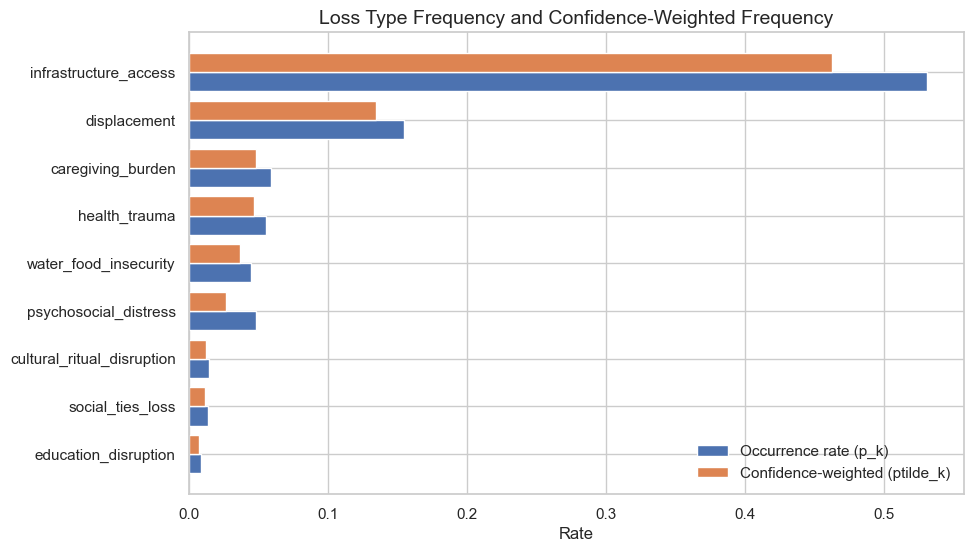

,loss,occurrence_rate,weighted_rate,mean_conf_when_present
0,infrastructure_access,0.530702,0.462112,0.870757
1,displacement,0.154521,0.134683,0.871616
2,caregiving_burden,0.058704,0.048448,0.825287
3,health_trauma,0.055668,0.047031,0.844848
4,water_food_insecurity,0.044534,0.036910,0.828788
5,psychosocial_distress,0.048246,0.026429,0.772000
6,cultural_ritual_disruption,0.014170,0.012011,0.847619
7,social_ties_loss,0.013495,0.011471,0.850000
8,education_disruption,0.008772,0.007524,0.857692


In [50]:
# NLE Frequency & Confidence

# Prepare a tidy table of metrics per loss type
rows = []
for k in LOSS:
    p = DF[f"loss_{k}_present"].mean(skipna=True) if f"loss_{k}_present" in DF.columns else np.nan
    w = (DF[f"loss_{k}_present"] * DF[f"loss_{k}_confidence"]).mean(skipna=True) if f"loss_{k}_confidence" in DF.columns and f"loss_{k}_present" in DF.columns else np.nan
    cbar = DF.loc[DF.get(f"loss_{k}_present", False) == True, f"loss_{k}_confidence"].mean(skipna=True) if f"loss_{k}_confidence" in DF.columns and f"loss_{k}_present" in DF.columns else np.nan
    rows.append({"loss": k, "occurrence_rate": p, "weighted_rate": w, "mean_conf_when_present": cbar})

freq_df = pd.DataFrame(rows).sort_values("weighted_rate", ascending=False)
freq_df.reset_index(drop=True, inplace=True)

# Plot p_k vs ptilde_k
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
idx = np.arange(len(freq_df))
ax.barh(idx + 0.2, freq_df['occurrence_rate'], height=bar_width, label='Occurrence rate (p_k)')
ax.barh(idx - 0.2, freq_df['weighted_rate'], height=bar_width, label='Confidence-weighted (ptilde_k)')
ax.set_yticks(idx)
ax.set_yticklabels(freq_df['loss'])
ax.invert_yaxis()
ax.set_xlabel('Rate')
ax.set_title('Loss Type Frequency and Confidence-Weighted Frequency')
ax.legend()
plt.show()

freq_df.head(20)


### NLE Frequency
- **Metrics:**
    - **Occurrence Rate:** $p_k = \text{mean}(present_k)$
    - **Confidence-Weighted Rate:** $\tilde p_k = \frac{1}{N}\sum 1[present_k]\cdot conf_k$
    - **Mean Confidence when Present:** $\bar c_k = \text{mean}(conf_k \mid present_k)$
- **Chart:** Horizontal bar chart (juxtaposing $p_k$ and $\tilde {p_k}$), sorted by $\tilde {p_k}$.
- **Interpretation:** If a class has low $p_k$ and low $\bar c_k$, it suggests **weak social media visibility** or model difficulty.

- **Observed (this dataset, N≈2964 posts):**
    - **High-visibility Top 1 `infrastructure_access`**: $p=53.1\%$, $\tilde p=46.2\%$, $\bar c=0.871$.
    - **High-visibility Top 2 `displacement`**: $p=15.5\%$, $\tilde p=13.5\%$, $\bar c=0.872$.
    - **Low-visibility `cultural_ritual_disruption`**: ($p=1.4\%$, $\tilde p=1.2\%$), `social_ties_loss` ($p=1.3\%$, $\tilde p=1.1\%$), `education_disruption` ($p=0.9\%$, $\tilde p=0.75\%$).
    - Social media provides strong, high-confidence visibility for infrastructure disruptions (and, to a lesser degree, displacement).
    - Caregiving, health risks, water/food insecurity, education, social ties, and cultural/ritual disruption are rarely captured—either because they occur less often on camera or because they are harder to evidence visually.
    - The largest gap between raw and weighted rates is for psychosocial distress, consistent with hard-to-verify emotional content. 

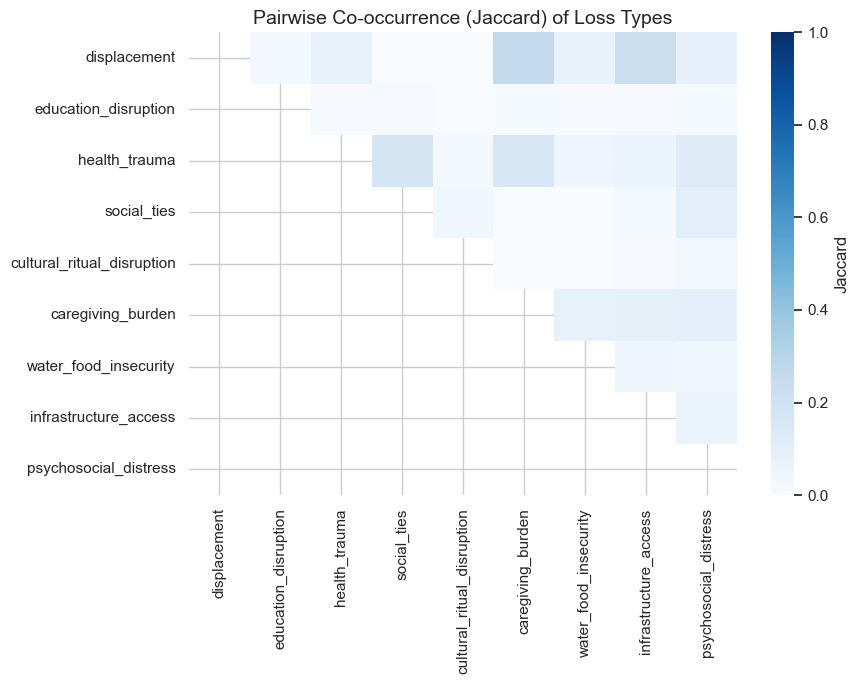

,loss_i,loss_j,jaccard
4,displacement,caregiving_burden,0.264000
6,displacement,infrastructure_access,0.228675
15,health_trauma,social_ties,0.171429
17,health_trauma,caregiving_burden,0.156997
20,health_trauma,psychosocial_distress,0.128205
25,social_ties,psychosocial_distress,0.102410
32,caregiving_burden,psychosocial_distress,0.096886
31,caregiving_burden,infrastructure_access,0.087119
7,displacement,psychosocial_distress,0.084838
1,displacement,health_trauma,0.081597


In [51]:
# NLE Pairwise Co-occurrence 

# Build Jaccard matrix over present flags
loss_flags = DF[PRESENT].fillna(False).astype(bool)
labels = [c.replace('loss_','').replace('_present','') for c in loss_flags.columns]

jac = np.zeros((len(labels), len(labels)), dtype=float)
for i in range(len(labels)):
    a = loss_flags.iloc[:, i].to_numpy()
    for j in range(len(labels)):
        b = loss_flags.iloc[:, j].to_numpy()
        inter = (a & b).sum()
        union = (a | b).sum()
        jac[i, j] = (inter / union) if union else 0.0

jac_df = pd.DataFrame(jac, index=labels, columns=labels)

# Plot upper-triangle heatmap
mask = np.triu(np.ones_like(jac_df, dtype=bool), k=1)
plt.figure(figsize=(9, 7))
sns.heatmap(jac_df, mask=~mask, cmap='Blues', vmin=0, vmax=1, cbar_kws={'label':'Jaccard'})
plt.title('Pairwise Co-occurrence (Jaccard) of Loss Types')
plt.tight_layout()
plt.show()

# Top co-occurring pairs
pairs = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        pairs.append((labels[i], labels[j], jac[i, j]))

top_pairs = pd.DataFrame(pairs, columns=['loss_i','loss_j','jaccard']).sort_values('jaccard', ascending=False).head(15)
top_pairs


 ### NLE Pairwise Co-occurrence 
 **Metric:** Jaccard: $J_{ij}=\frac{\|L_i\cap L_j\|}{\|L_i\cup L_j\|}$
- **Chart:** 9x9 heatmap (upper triangle).
- Co-occurrence is sparse, with a few interpretable hubs; most low-base-rate classes remain isolated—consistent with their scarcity in Plan 1.
- **Strongest pair**: Displacement ↔ Caregiving burden (Jaccard ≈ 0.26). 
  - Interpretation: Evacuation/temporary living arrangements increase care difficulty for children/elderly/disabled—high face validity.
- **Mobility pathway**: Displacement ↔ Infrastructure access (≈ 0.23). 
  - Interpretation: Blocked roads/bridges and closed facilities plausibly precipitate relocation. 
- **Health hub**: Health/trauma co-occurs with
  - Social ties loss (≈ 0.17),
  - Caregiving burden (≈ 0.16),
  - Psychosocial distress (≈ 0.13).
  - Interpretation: Injury/illness tends to appear with family separation, increased caregiving demands, and emotional distress.
- The graph reveals plausible mechanistic bundles—(i) mobility–relocation–care (infrastructure ↔ displacement ↔ caregiving), and (ii) health–social–emotion (health/trauma with social ties loss and distress)—while resource and school/ritual disruptions remain visibility-limited on social media.

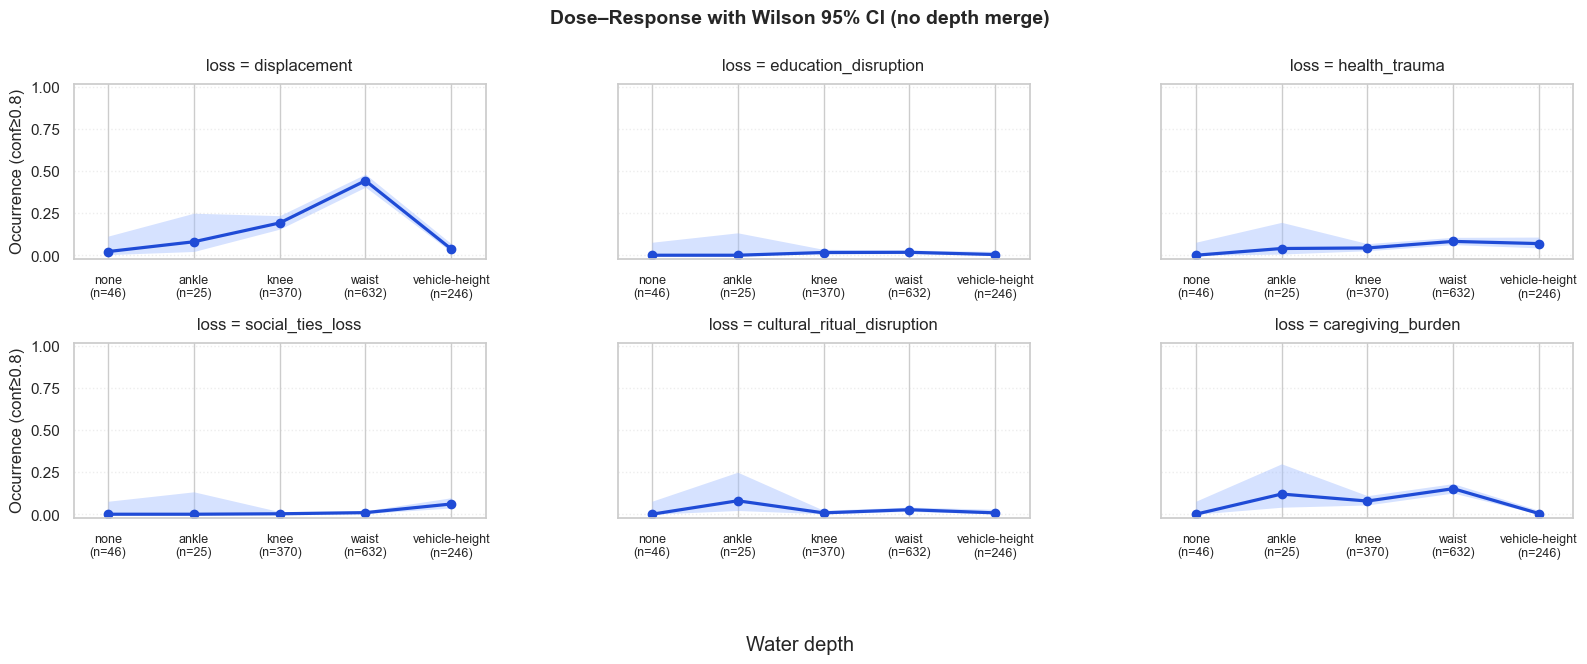

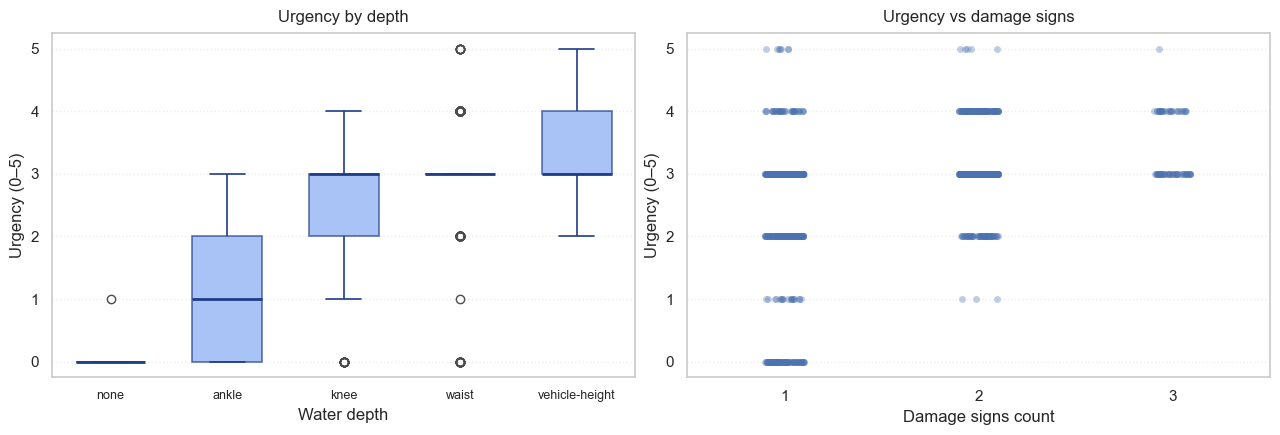

In [52]:
#  NLE Relationship with Water Depth / Urgency Score

LOSS_ORDER = LOSS[:]
line_color = "#1f4bd6"
fill_color = "#a4bfff"

from statsmodels.stats import proportion as sm

# Filter to ground/indoor scenes with valid depth, drop indoor_flood
analysis_depth = DF.copy()
mask_scene = (analysis_depth["scene_ground_outdoor"] == True) | (analysis_depth["scene_indoor"] == True)
analysis_depth = analysis_depth.loc[mask_scene].copy()
analysis_depth = analysis_depth[analysis_depth['water_depth_bin'].isin(['none','ankle','knee','waist','vehicle_height'])]

# Recompute rates per original depth levels
DEPTH_LEVELS = ['none','ankle','knee','waist','vehicle_height']
depth_labels = {
    'none': 'none',
    'ankle': 'ankle',
    'knee': 'knee',
    'waist': 'waist',
    'vehicle_height': 'vehicle-height'
}

rows = []
for k in LOSS_ORDER:
    for depth, grp in analysis_depth.groupby('water_depth_bin', observed=False):
        present_col = f"loss_{k}_present"
        conf_col = f"loss_{k}_confidence"
        subset = grp[[present_col, conf_col]].dropna()
        counts = len(subset)
        if counts == 0:
            rate = lo = hi = np.nan
        else:
            hi_mask = (subset[present_col] == True) & (subset[conf_col] >= 0.8)
            c = hi_mask.sum()
            lo, hi = sm.proportion_confint(c, counts, method='wilson')
            rate = c / counts
        rows.append({'loss': k, 'depth': depth, 'n': counts, 'rate': rate, 'lo': lo, 'hi': hi})

rows_clean = []
for k in LOSS_ORDER:
    for depth in DEPTH_LEVELS:
        row = next((r for r in rows if r['loss']==k and r['depth']==depth), None)
        if row is None:
            rows_clean.append({'loss':k,'depth':depth,'n':0,'rate':np.nan,'lo':np.nan,'hi':np.nan})
        else:
            rows_clean.append(row)

dose_depth = pd.DataFrame(rows_clean)

# Sample counts for xticks
depth_counts = analysis_depth.groupby('water_depth_bin').size().reindex(DEPTH_LEVELS).fillna(0).astype(int)
xtick_labels = [f"{depth_labels[d]}\n(n={depth_counts.loc[d]})" for d in DEPTH_LEVELS]

fig, axes = plt.subplots(2, 3, figsize=(16, 6.2), sharey=True)
axes = axes.flatten()

for ax, loss_name in zip(axes, LOSS_ORDER):
    sub = dose_depth[dose_depth['loss'] == loss_name].set_index('depth').reindex(DEPTH_LEVELS)
    x_pos = np.arange(len(DEPTH_LEVELS))
    rate = sub['rate'].to_numpy(dtype=float)
    lo = sub['lo'].to_numpy(dtype=float)
    hi = sub['hi'].to_numpy(dtype=float)

    ax.fill_between(x_pos, lo, hi, color=fill_color, alpha=0.45, linewidth=0, zorder=1)
    ax.plot(x_pos, rate, '-o', color=line_color, linewidth=2.3, markersize=6, zorder=2)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(xtick_labels, fontsize=9)
    ax.tick_params(axis='x', pad=5)
    ax.set_xlim(-0.4, len(DEPTH_LEVELS)-0.6)
    ax.set_ylim(-0.02, 1.02)
    ax.grid(axis='y', linestyle=':', alpha=0.35)
    ax.set_title(f"loss = {loss_name}", fontsize=12, pad=10)
    if ax in (axes[0], axes[3]):
        ax.set_ylabel("Occurrence (conf≥0.8)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for idx in range(len(LOSS_ORDER), len(axes)):
    axes[idx].axis('off')

fig.suptitle("Dose–Response with Wilson 95% CI (no depth merge)", y=1.05, fontsize=14, fontweight='semibold')
fig.supxlabel("Water depth")
plt.tight_layout(pad=1.1)
plt.subplots_adjust(top=0.93, bottom=0.23, hspace=0.48, wspace=0.32)
plt.show()

# Urgency visuals (box + swarm, strip + mean trend)
depth_cat = pd.Categorical(analysis_depth['water_depth_bin'], categories=DEPTH_LEVELS, ordered=True)
analysis_depth = analysis_depth.assign(depth_ord=depth_cat)

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.6))

box_color = "#87aaf5"
line_color = "#1f3c88"
sns.boxplot(
    data=analysis_depth,
    x='depth_ord',
    y='urgency_score',
    order=DEPTH_LEVELS,
    ax=axes[0],
    width=0.6,
    boxprops=dict(facecolor=box_color, alpha=0.7, edgecolor=line_color, linewidth=1.2),
    medianprops=dict(color=line_color, linewidth=2.0),
    whiskerprops=dict(color=line_color, linewidth=1.2),
    capprops=dict(color=line_color, linewidth=1.2),
    saturation=1.0,
)
axes[0].set_xticks(np.arange(len(DEPTH_LEVELS)))
axes[0].set_xticklabels([depth_labels[d] for d in DEPTH_LEVELS], rotation=0)
axes[0].tick_params(axis='x', labelsize=9, pad=3)
axes[0].set_xlim(-0.5, len(DEPTH_LEVELS)-0.5)
axes[0].set_title("Urgency by depth", fontsize=12, pad=8)
axes[0].set_xlabel("Water depth")
axes[0].set_ylabel("Urgency (0–5)")
axes[0].grid(axis='y', linestyle=':', alpha=0.35)

sns.stripplot(data=analysis_depth, x='damage_signs_count', y='urgency_score', alpha=0.35, ax=axes[1])
axes[1].set_title("Urgency vs damage signs", fontsize=12, pad=8)
axes[1].set_xlabel("Damage signs count")
axes[1].set_ylabel("Urgency (0–5)")
axes[1].grid(axis='y', linestyle=':', alpha=0.35)

plt.tight_layout(pad=0.6)
plt.subplots_adjust(bottom=0.18)
plt.show()


### NLE Relationship with Water Depth / Urgency Score
- Dose–response of loss types vs. water depth
  - Infrastructure access: monotonic increase from none → ankle → knee → waist → vehicle-height with tight CIs at deeper bins — consistent with road closures, building ingress, and service interruptions becoming more visible as depth rises.
  - Displacement peaks at knee–waist and drops at vehicle-height/indoor, suggesting evacuations and short-range relocations are most frequently captured at moderate depths, while very deep scenes show fewer people in transit and more fixed damage.
  - Caregiving burden shows a weak hump at knee–waist and remains low overall, indicating limited visual capture of caregiving acts even in severe flooding (visibility bias).
  - Health/trauma and psychosocial distress remain rare, implying these outcomes are under-represented in visuals relative to infrastructure impacts.
- Urgency vs. depth and damage
  - Urgency increases step-wise with depth.
  - Urgency correlates positively (though noisily) with damage signs count (1→3), indicating that scenes showing multiple damage cues are more likely to be judged urgent.
- Interpretation & implications
  - Social media most reliably reflects infrastructure disruption under flooding; individual-level losses (caregiving, health, psychosocial) are harder to verify visually, even in severe conditions.
  - The monotonic urgency–depth relation validates our urgency scale as a hazard-sensitive proxy.

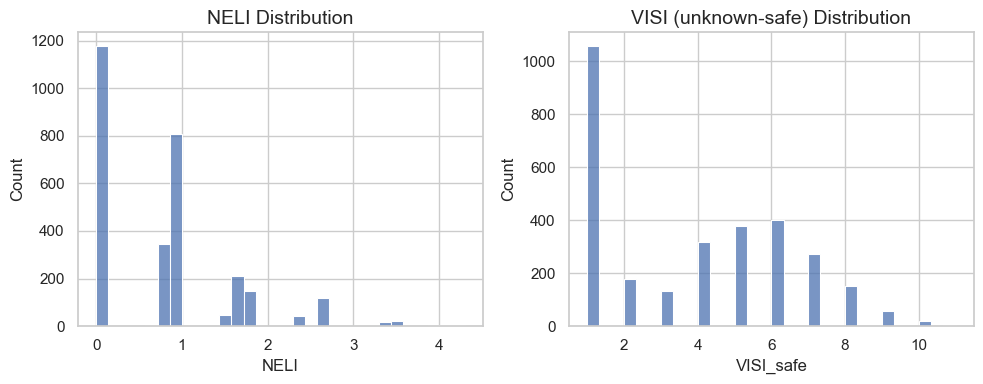

Spearman correlations (kept features):
                  NELI  VISI_safe  urgency_score  depth_level_num  \
NELI             1.000      0.760          0.822            0.654   
VISI_safe        0.760      1.000          0.796            0.841   
urgency_score    0.822      0.796          1.000            0.775   
depth_level_num  0.654      0.841          0.775            1.000   
damage_capped    0.594      0.679          0.682            0.561   

                 damage_capped  
NELI                     0.594  
VISI_safe                0.679  
urgency_score            0.682  
depth_level_num          0.561  
damage_capped            1.000  


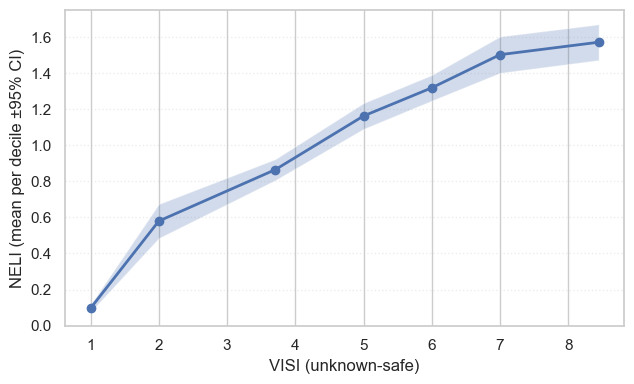

In [53]:
# Composite Indicators: NELI and VISI

# --- NELI ---
conf_cols = [f'loss_{k}_confidence' for k in LOSS]
pres_cols = [f'loss_{k}_present' for k in LOSS]
NELI = (DF[conf_cols].fillna(0.0).values * DF[pres_cols].fillna(False).astype(bool).values).sum(axis=1)
DF['NELI'] = NELI

valid_depth  = ['none','ankle','knee','waist','vehicle_height']
depth_to_num = {d:i for i,d in enumerate(valid_depth)}          # 0..4
valid_crowd  = ['1','2-5','6-20','>20']
crowd_to_num = {d:i for i,d in enumerate(valid_crowd)}          # 0..3

DF['depth_level_num'] = DF['water_depth_bin'].astype(str).map(depth_to_num).fillna(0)
DF['crowd_size_num']  = DF['crowd_size_bin'].astype(str).map(crowd_to_num).fillna(0)
DF['damage_capped']   = DF['damage_signs_count'].fillna(0).clip(0, 3)
DF['VISI_safe'] = (
    DF['depth_level_num'] +
    DF['damage_capped'] +
    DF['crowd_size_num'] +
    DF['relief_visible'].fillna(False).astype(int)
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(DF['NELI'], bins=30, ax=axes[0]); axes[0].set_title('NELI Distribution')
sns.histplot(DF['VISI_safe'], bins=30, ax=axes[1]); axes[1].set_title('VISI (unknown-safe) Distribution')
plt.tight_layout(); plt.show()

cols = ['NELI','VISI_safe','urgency_score','depth_level_num','damage_capped']
print("Spearman correlations (kept features):")
print(DF[cols].corr(method='spearman').round(3))

import numpy as np
q = np.linspace(0, 1, 11)  
cuts = DF['VISI_safe'].quantile(q).to_numpy()
cuts[0] -= 1e-9; cuts[-1] += 1e-9
DF['_visi_bin'] = pd.cut(DF['VISI_safe'], bins=cuts, include_lowest=True, duplicates='drop')
agg = DF.groupby('_visi_bin', observed=False).agg(
    visi_mean=('VISI_safe','mean'),
    n=('NELI','size'),
    neli_mean=('NELI','mean'),
    neli_std=('NELI','std')
).dropna()
agg['neli_se'] = (agg['neli_std'] / np.sqrt(agg['n'].clip(lower=1))).fillna(0)
agg['lo'] = (agg['neli_mean'] - 1.96*agg['neli_se']).clip(lower=0)
agg['hi'] = agg['neli_mean'] + 1.96*agg['neli_se']

plt.figure(figsize=(6.5,4))
plt.plot(agg['visi_mean'], agg['neli_mean'], '-o', lw=2)
plt.fill_between(agg['visi_mean'], agg['lo'], agg['hi'], alpha=0.25)
plt.xlabel('VISI (unknown-safe)'); plt.ylabel('NELI (mean per decile ±95% CI)')
plt.grid(axis='y', linestyle=':', alpha=0.35); plt.tight_layout(); plt.show()

DF.drop(columns=['_visi_bin'], errors='ignore', inplace=True)


### Composite Indicators: NELI and VISI
- We quantify per-post non-economic loss with NELI (sum of loss category confidences) and visual hazard intensity with VISI (depth, capped damage, crowding, relief).
- Both signals are right-skewed, indicating a large mass of low-intensity posts and relatively few extreme cases.
- NELI strongly correlates with VISI (ρ≈0.76) and with perceived urgency (ρ≈0.82), while VISI also correlates with urgency (ρ≈0.80). Among VISI factors, water depth (ρ≈0.65) and damage signs (ρ≈0.59) are the primary drivers of NELI.
- Binning posts by VISI deciles yields a monotonic increase in mean NELI with narrow 95% CIs, establishing a robust dose–response between visible hazard intensity and verifiable non-economic losses.

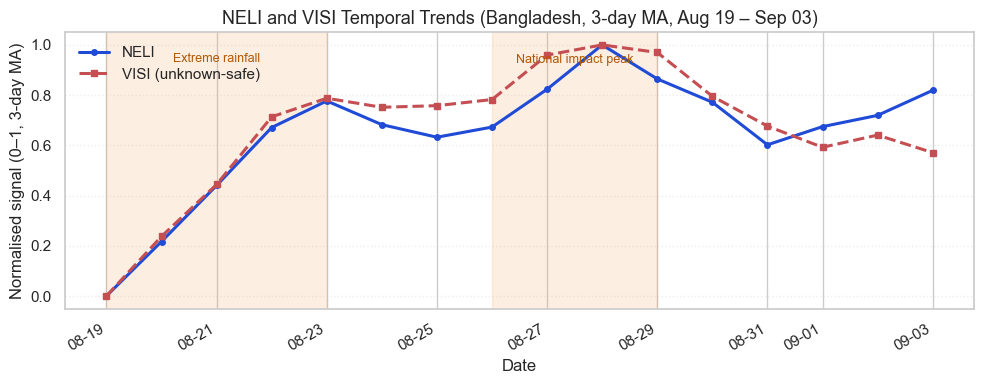

In [54]:
# Temporal Change (using NELI and VISI)
region_focus = 'bangladesh'  # Focus region for temporal analysis

if 'region' in DF.columns:
    # Ensure NELI and VISI_safe are computed (if not already)
    if 'NELI' not in DF.columns or 'VISI_safe' not in DF.columns:
        print("⚠️ NELI or VISI_safe not found. Please run the Composite Indicators cell first.")
    else:
        DF_region = DF[DF['region'].astype(str).str.lower() == region_focus].copy()
        if DF_region.empty:
            print(f"⚠️ No records found for region='{region_focus}'.")
        else:
            TS = DF_region.set_index('ts').sort_index()
            
            # Calculate daily mean NELI and VISI_safe
            daily_neli = TS.resample('D')['NELI'].mean()
            daily_visi = TS.resample('D')['VISI_safe'].mean()
            
            # Apply 3-day moving average
            neli_ma = daily_neli.rolling(window=3, min_periods=1).mean()
            visi_ma = daily_visi.rolling(window=3, min_periods=1).mean()
            
            # Filter to date range
            tzinfo = neli_ma.index.tz
            mask = (neli_ma.index >= pd.Timestamp('2024-08-19', tz=tzinfo)) & (neli_ma.index <= pd.Timestamp('2024-09-03', tz=tzinfo))
            neli_ma = neli_ma.loc[mask].dropna()
            visi_ma = visi_ma.loc[mask].dropna()
            
            if neli_ma.empty or visi_ma.empty:
                print("⚠️ No data in the specified date window (2024-08-19 to 2024-09-03).")
            else:
                # Remove timezone for plotting
                neli_ma.index = neli_ma.index.tz_localize(None)
                visi_ma.index = visi_ma.index.tz_localize(None)
                
                # Normalize both to 0-1 range for comparison
                def normalize_series(s):
                    min_val, max_val = s.min(), s.max()
                    if np.isclose(max_val - min_val, 0):
                        return s - min_val
                    return (s - min_val) / (max_val - min_val)
                
                neli_norm = normalize_series(neli_ma)
                visi_norm = normalize_series(visi_ma)
                
                import matplotlib.dates as mdates
                fig, ax = plt.subplots(figsize=(10, 4))
                
                # Plot NELI
                ax.plot(neli_norm.index, neli_norm.values, color="#1f4bd6", linewidth=2.2, label='NELI', marker='o', markersize=4)
                
                # Plot VISI_safe
                ax.plot(visi_norm.index, visi_norm.values, color="#c44e52", linewidth=2.2, label='VISI (unknown-safe)', marker='s', markersize=4, linestyle='--')
                
                ax.set_ylabel('Normalised signal (0–1, 3-day MA)')
                ax.set_xlabel('Date')
                ax.legend(loc='upper left')
                locator = mdates.AutoDateLocator(minticks=8, maxticks=15)
                formatter = mdates.DateFormatter('%m-%d')
                ax.xaxis.set_major_locator(locator)
                ax.xaxis.set_major_formatter(formatter)
                fig.autofmt_xdate()
                ax.grid(axis='y', linestyle=':', alpha=0.35)
                ax.set_title('NELI and VISI Temporal Trends (Bangladesh, 3-day MA, Aug 19 – Sep 03)', fontsize=13)
                
                # Event bands
                events = [
                    (pd.Timestamp('2024-08-19'), pd.Timestamp('2024-08-23'), 'Extreme rainfall'),
                    (pd.Timestamp('2024-08-26'), pd.Timestamp('2024-08-29'), 'National impact peak')
                ]
                for start, end, label in events:
                    ax.axvspan(start, end, color='#f4a261', alpha=0.18)
                    ax.text((start + (end-start)/2), ax.get_ylim()[1]*0.92, label,
                            ha='center', va='top', fontsize=9, color='#b35806')
                
                plt.tight_layout()
                plt.show()
else:
    print("⚠️ Column 'region' not found.")


### Temporal Change (using NELI and VISI)
- We normalise daily means of NELI and VISI to [0,1] within the window and apply a 3-day moving average; shaded bands mark reported extreme rainfall (Aug 19–23) and national impact peak (Aug 26–29).
- VISI and NELI rise during the extreme-rainfall window (Aug 19–23), peak around Aug 28–29, and remain elevated afterwards, mirroring reports of late-August nationwide impact. This supports social posts as a timely proxy for non-economic flood consequences.

Spearman correlations with urgency (higher absolute value = stronger association):
              feature  spearman_rho    n
Water depth (ordinal)         0.530 1519
   Damage signs count         0.413 1519
 Crowd size (ordinal)         0.148 1064
 Relief visible (0/1)         0.021 1519

Urgency by water depth (mean ± std) and change vs previous level:
                 mean   std  count  mean_diff_vs_prev
water_depth_bin                                      
none            0.022 0.147     46                NaN
ankle           1.040 0.889     25              1.018
knee            2.468 0.759    380              1.428
waist           3.022 0.748    729              0.554
vehicle_height  3.348 0.593    339              0.326

Largest upward shift occurs between ankle → knee (Δ mean urgency = 1.428).


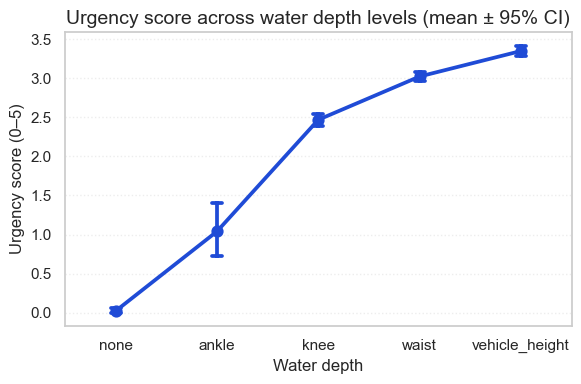

In [55]:
# Which cues track urgency?
analysis_df = DF.copy()

# Map ordered categories to numeric scores for correlation (drop indoor_flood)
ordered_depth = [d for d in DEPTH_ORDER if d not in ('unknown', 'indoor_flood')]
depth_map = {d: i for i, d in enumerate(ordered_depth)}
analysis_df = analysis_df[analysis_df['water_depth_bin'].isin(ordered_depth)].copy()
analysis_df['depth_level_num'] = analysis_df['water_depth_bin'].astype(str).map(depth_map)

ordered_crowd = ["1", "2-5", "6-20", ">20"]
crowd_map = {d: i for i, d in enumerate(ordered_crowd)}
analysis_df['crowd_size_num'] = analysis_df['crowd_size_bin'].astype(str).map(crowd_map)

analysis_df['relief_visible_num'] = analysis_df['relief_visible'].astype(float)

feature_info = [
    ('depth_level_num', 'Water depth (ordinal)'),
    ('damage_signs_count', 'Damage signs count'),
    ('crowd_size_num', 'Crowd size (ordinal)'),
    ('relief_visible_num', 'Relief visible (0/1)')
]

rows = []
for col, label in feature_info:
    valid = analysis_df[['urgency_score', col]].dropna()
    if len(valid) >= 5:
        rho = valid['urgency_score'].corr(valid[col], method='spearman')
        rows.append({'feature': label, 'spearman_rho': rho, 'n': len(valid)})

corr_df = pd.DataFrame(rows).sort_values('spearman_rho', ascending=False)
print("Spearman correlations with urgency (higher absolute value = stronger association):")
print(corr_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Threshold effect: urgency vs depth
urg_depth = (
    analysis_df[analysis_df['water_depth_bin'].isin(ordered_depth)]
    .groupby('water_depth_bin', observed=False)['urgency_score']
    .agg(mean='mean', std='std', count='size')
    .reindex(ordered_depth)
)
urg_depth['mean_diff_vs_prev'] = urg_depth['mean'].diff()
print("\nUrgency by water depth (mean ± std) and change vs previous level:")
print(urg_depth[['mean', 'std', 'count', 'mean_diff_vs_prev']].to_string(float_format=lambda x: f"{x:.3f}"))

positive_diffs = urg_depth['mean_diff_vs_prev'].dropna()
if not positive_diffs.empty:
    jump_level = positive_diffs.idxmax()
    jump_value = positive_diffs.loc[jump_level]
    prev_idx = ordered_depth.index(jump_level) - 1
    prev_level = ordered_depth[prev_idx] if prev_idx >= 0 else None
    print(f"\nLargest upward shift occurs between {prev_level} → {jump_level} (Δ mean urgency = {jump_value:.3f}).")

plt.figure(figsize=(6, 4))
sns.pointplot(
    data=analysis_df[analysis_df['water_depth_bin'].isin(ordered_depth)],
    x='water_depth_bin', y='urgency_score', order=ordered_depth,
    estimator=np.mean, errorbar=('ci', 95), capsize=0.1, color='#1f4bd6'
)
plt.title('Urgency score across water depth levels (mean ± 95% CI)')
plt.xlabel('Water depth')
plt.ylabel('Urgency score (0–5)')
plt.grid(axis='y', linestyle=':', alpha=0.35)
plt.tight_layout()
plt.show()


### Urgency Analysis
- Water depth is the dominant driver of urgency. Spearman ρ ≈ 0.53 (n≈1.5k), the largest among all cues.
- Knee-level water is a practical “hazard salience” threshold—once scenes pass knee depth, posts are far more likely to be judged urgent.
- Water depth larger means more urgent, which is consistant with real life experience.

Overall visibility (share of posts showing each group):
              rate
Pregnant     0.001
Disabled aid 0.002
Elderly      0.036
Children     0.188
Female       0.293
Male         0.499


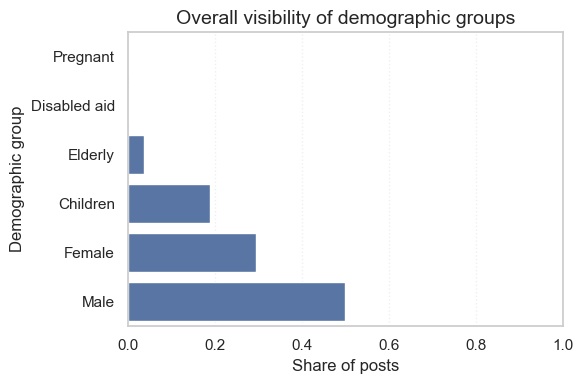


Demographic visibility when caregiving burden is present vs absent:
       group  rate_with_caregiving  rate_without_caregiving  difference
    Children                 0.925                    0.142       0.783
      Female                 0.885                    0.256       0.629
        Male                 0.839                    0.477       0.362
     Elderly                 0.138                    0.030       0.108
Disabled aid                 0.017                    0.001       0.017
    Pregnant                 0.006                    0.001       0.005


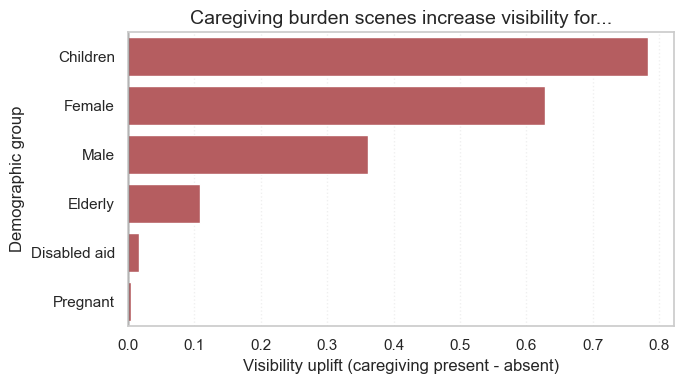


Groups with lowest visibility overall: ['Pregnant', 'Disabled aid']
Groups most visible overall: ['Male', 'Female']


In [56]:
# Demographic Presence analysis
DEMO_MAP = {
    'demo_children': 'Children',
    'demo_elderly': 'Elderly',
    'demo_pregnant': 'Pregnant',
    'demo_disabled_aid': 'Disabled aid',
    'demo_male': 'Male',
    'demo_female': 'Female'
}
demo_cols = [col for col in DEMO_MAP if col in DF.columns]
if not demo_cols:
    print("⚠️ Demographic columns not found in DF; skipping analysis.")
else:
    demo_labels = [DEMO_MAP[c] for c in demo_cols]

    # Overall visibility
    overall = DF[demo_cols].astype(float).mean().rename(index=DEMO_MAP).sort_values()
    print("Overall visibility (share of posts showing each group):")
    print(overall.to_frame('rate').to_string(formatters={'rate': '{:.3f}'.format}))

    plt.figure(figsize=(6, 4))
    sns.barplot(x=overall.values, y=overall.index, color="#4C72B0")
    plt.xlabel('Share of posts')
    plt.ylabel('Demographic group')
    plt.title('Overall visibility of demographic groups')
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Loss association: caregiving vs. demographics
    if 'loss_caregiving_burden_present' in DF.columns:
        care_mask = DF['loss_caregiving_burden_present'] == True
        assoc_rows = []
        for col in demo_cols:
            rate_care = DF.loc[care_mask, col].astype(float).mean()
            rate_other = DF.loc[~care_mask, col].astype(float).mean()
            assoc_rows.append({
                'group': DEMO_MAP[col],
                'rate_with_caregiving': rate_care,
                'rate_without_caregiving': rate_other,
                'difference': rate_care - rate_other
            })
        assoc_df = pd.DataFrame(assoc_rows).sort_values('difference', ascending=False)
        print("\nDemographic visibility when caregiving burden is present vs absent:")
        print(assoc_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

        plt.figure(figsize=(7, 4))
        sns.barplot(data=assoc_df, x='difference', y='group', color="#C44E52")
        plt.axvline(0, color='k', linewidth=1)
        plt.xlabel('Visibility uplift (caregiving present - absent)')
        plt.ylabel('Demographic group')
        plt.title('Caregiving burden scenes increase visibility for...')
        plt.grid(axis='x', linestyle=':', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Summary text
    low_visibility = overall.nsmallest(2).index.tolist()
    high_visibility = overall.nlargest(2).index.tolist()
    print(f"\nGroups with lowest visibility overall: {low_visibility}")
    print(f"Groups most visible overall: {high_visibility}")

### Demographic Presence analysis
- Social media disproportionately shows adult men and, to a lesser extent, women; vulnerable groups (elderly, pregnant, disabled aid) are largely under-represented.
- Caregiving scenes strongly surface dependents (children) and female caregivers, with smaller but consistent uplifts for elderly and other vulnerable subgroups. This supports the interpretation that caregiving episodes function as a visibility “gate” for otherwise scarce demographics.

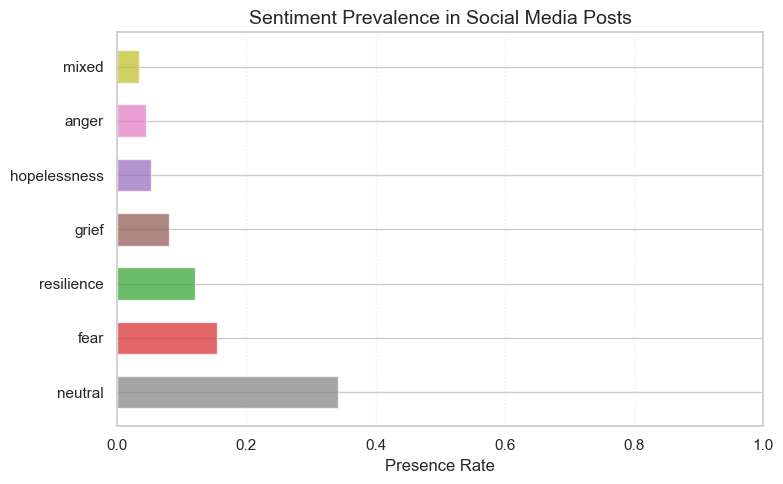

Sentiment prevalence summary:
      sentiment  presence_rate  weighted_rate  mean_confidence
5       neutral          0.342          0.271            0.792
0          fear          0.154          0.117            0.760
4    resilience          0.121          0.087            0.723
2         grief          0.080          0.061            0.754
1  hopelessness          0.052          0.037            0.720
3         anger          0.044          0.033            0.756
6         mixed          0.034          0.024            0.720


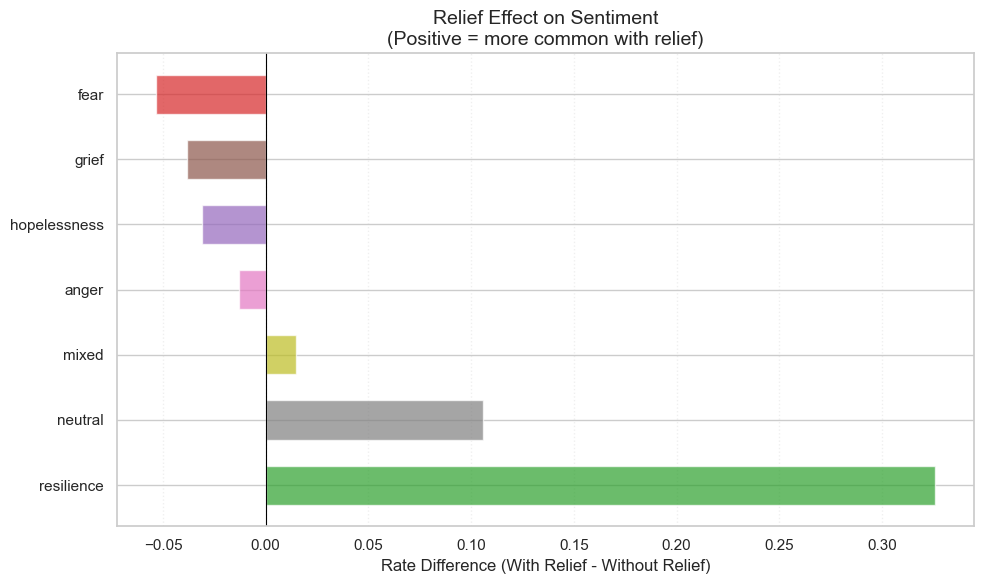


Relief effect on sentiment:
      sentiment  with_relief  without_relief  difference
4    resilience        0.379           0.053       0.326
5       neutral        0.426           0.320       0.106
6         mixed        0.045           0.031       0.015
3         anger        0.034           0.047      -0.013
1  hopelessness        0.028           0.058      -0.031
2         grief        0.050           0.088      -0.038
0          fear        0.112           0.165      -0.053


In [57]:
# Sentiment Analysis: Relationship with intensity/loss/relief

# Define sentiment labels (ordered by typical prevalence: neutral > mixed > negative emotions > resilience)
SENTIMENT_LABELS = ['fear', 'hopelessness', 'grief', 'anger', 'resilience', 'neutral', 'mixed']
SENTIMENT_COLORS = {
    'fear': '#d62728',
    'hopelessness': '#9467bd',
    'grief': '#8c564b',
    'anger': '#e377c2',
    'resilience': '#2ca02c',
    'neutral': '#7f7f7f',
    'mixed': '#bcbd22'
}

# Calculate overall sentiment prevalence (using confidence-weighted presence)
sentiment_stats = []
for sent in SENTIMENT_LABELS:
    present_col = f'sentiment_{sent}_present'
    conf_col = f'sentiment_{sent}_confidence'
    
    if present_col in DF.columns and conf_col in DF.columns:
        # Simple presence rate
        presence_rate = DF[present_col].fillna(False).astype(float).mean()
        # Confidence-weighted rate
        weighted_rate = (DF[present_col].fillna(False).astype(float) * DF[conf_col].fillna(0.0)).mean()
        # Mean confidence when present
        mask_present = DF[present_col].fillna(False) == True
        mean_conf = DF.loc[mask_present, conf_col].mean() if mask_present.sum() > 0 else 0.0
        
        sentiment_stats.append({
            'sentiment': sent,
            'presence_rate': presence_rate,
            'weighted_rate': weighted_rate,
            'mean_confidence': mean_conf
        })

sentiment_df = pd.DataFrame(sentiment_stats).sort_values('weighted_rate', ascending=False)

# Plot 1: Overall sentiment prevalence (unified style)
fig, ax = plt.subplots(figsize=(8, 5))

# Use consistent ordering and colors
colors_bar = [SENTIMENT_COLORS.get(s, '#7f7f7f') for s in sentiment_df['sentiment']]

# Bar chart: presence rates
ax.barh(sentiment_df['sentiment'], sentiment_df['presence_rate'], color=colors_bar, alpha=0.7, height=0.6)
ax.set_xlabel('Presence Rate')
ax.set_title('Sentiment Prevalence in Social Media Posts')
ax.set_xlim(0, 1)
ax.grid(axis='x', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()

print("Sentiment prevalence summary:")
print(sentiment_df[['sentiment', 'presence_rate', 'weighted_rate', 'mean_confidence']].round(3))

# Plot 2: Relief Effect on Sentiment (difference only, unified style)
if 'relief_visible' in DF.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Compare sentiment rates with and without relief
    relief_comparison = []
    for sent in SENTIMENT_LABELS:
        present_col = f'sentiment_{sent}_present'
        if present_col in DF.columns:
            mask_relief = DF['relief_visible'].fillna(False) == True
            mask_no_relief = DF['relief_visible'].fillna(False) == False
            
            rate_with_relief = DF.loc[mask_relief, present_col].fillna(False).astype(float).mean() if mask_relief.sum() > 0 else 0
            rate_without_relief = DF.loc[mask_no_relief, present_col].fillna(False).astype(float).mean() if mask_no_relief.sum() > 0 else 0
            
            relief_comparison.append({
                'sentiment': sent,
                'with_relief': rate_with_relief,
                'without_relief': rate_without_relief,
                'difference': rate_with_relief - rate_without_relief
            })
    
    relief_df = pd.DataFrame(relief_comparison).sort_values('difference', ascending=False)
    colors_relief = [SENTIMENT_COLORS.get(s, '#7f7f7f') for s in relief_df['sentiment']]
    
    # Bar chart: difference (relief effect) - unified style
    ax.barh(relief_df['sentiment'], relief_df['difference'], color=colors_relief, alpha=0.7, height=0.6)
    ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Rate Difference (With Relief - Without Relief)')
    ax.set_title('Relief Effect on Sentiment\n(Positive = more common with relief)')
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nRelief effect on sentiment:")
    print(relief_df[['sentiment', 'with_relief', 'without_relief', 'difference']].round(3))


### Sentiment Analysis
- Neutral descriptions are most frequent, followed by fear, resilience, and grief; anger, hopelessness, and mixed affect are rare. 
- Posts that visually depict relief efforts show a marked shift in affect: resilience increases by +0.33 (abs. rate), neutral by +0.11, while fear (−0.05), grief (−0.04), hopelessness (−0.03), and anger (−0.01) decrease. This pattern suggests that aid imagery is associated with recovery-oriented framing rather than acute distress.

Platform distribution: {'twitter': 1861, 'tiktok': 1103}



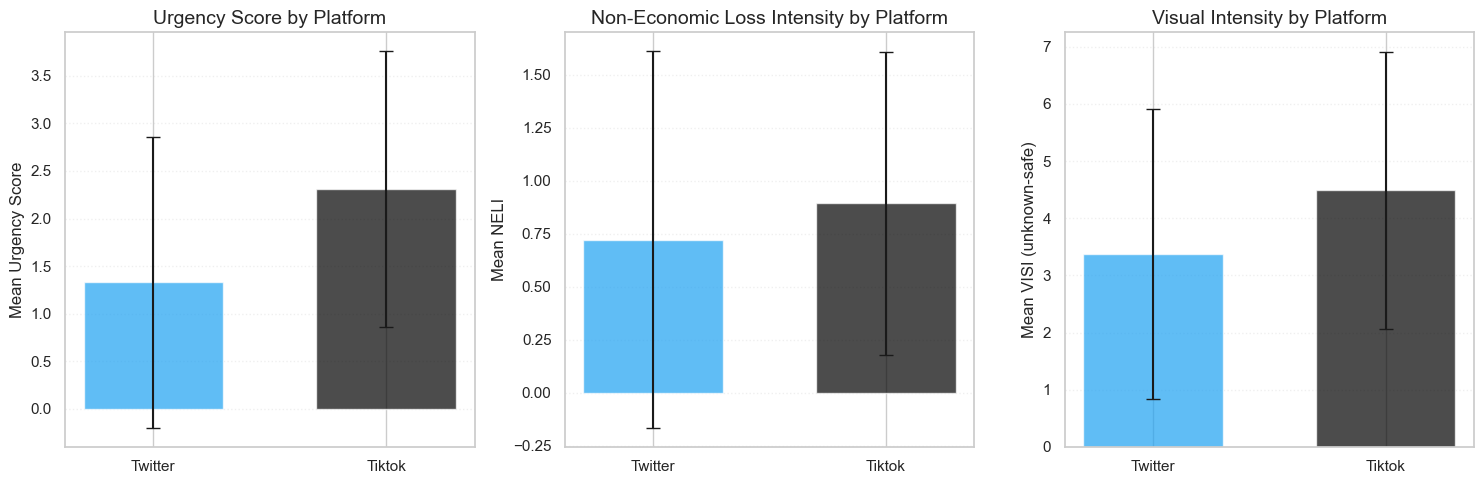

Platform comparison summary:
          urgency_mean  urgency_std  NELI_mean  NELI_std  VISI_mean  VISI_std
platform                                                                     
tiktok           2.311        1.448      0.893     0.715      4.486     2.423
twitter          1.329        1.529      0.723     0.890      3.368     2.539


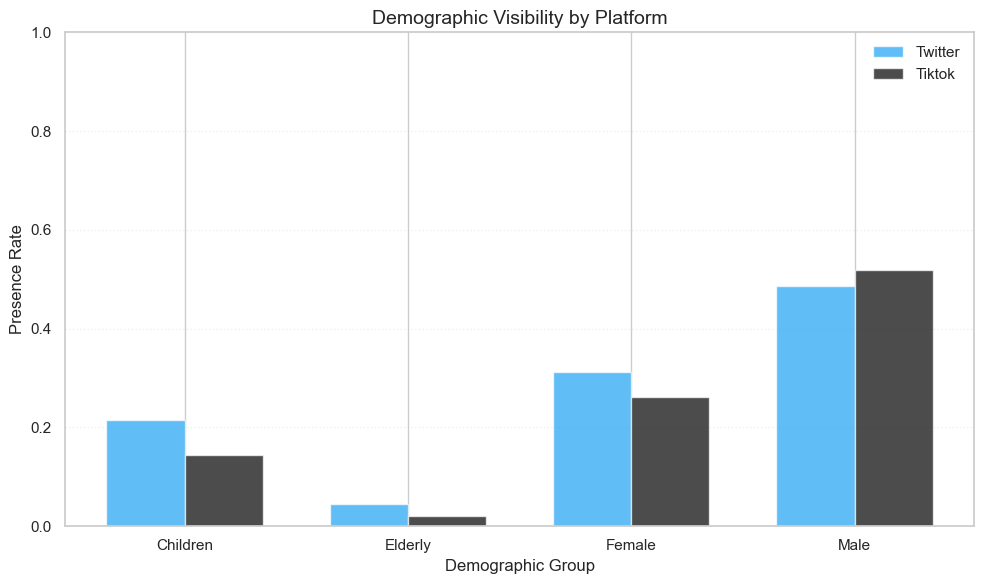


Demographic visibility rates:
platform     twitter  tiktok
demographic                 
children       0.214   0.143
elderly        0.046   0.020
female         0.312   0.262
male           0.486   0.519


In [58]:
# Stratified: Platform comparison (Twitter vs TikTok)

# Ensure platform column exists
if 'platform' not in DF.columns and 'source' in DF.columns:
    DF['platform'] = DF['source'].astype(str).str.lower()

if 'platform' not in DF.columns:
    print("⚠️ Platform column not found. Skipping platform comparison.")
else:
    # Filter to valid platforms
    platforms = ['twitter', 'tiktok']
    DF_platform = DF[DF['platform'].isin(platforms)].copy()
    
    if DF_platform.empty:
        print("⚠️ No data found for Twitter/TikTok platforms.")
    else:
        print(f"Platform distribution: {DF_platform['platform'].value_counts().to_dict()}\n")
        
        colors_platform = {'twitter': '#1DA1F2', 'tiktok': '#000000'}
        
        # 1. Three metrics comparison: Urgency Score, NELI, VISI (1 row, 3 columns)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        x_pos = np.arange(len(platforms))
        bar_colors = [colors_platform.get(p, '#7f7f7f') for p in platforms]
        
        # Urgency Score
        if 'urgency_score' in DF_platform.columns:
            urgency_stats = DF_platform.groupby('platform')['urgency_score'].agg(['mean', 'std', 'count'])
            urgency_stats = urgency_stats.reindex(platforms, fill_value=0)
            axes[0].bar(x_pos, urgency_stats['mean'], yerr=urgency_stats['std'],
                      color=bar_colors, alpha=0.7, capsize=5, width=0.6)
            axes[0].set_xticks(x_pos)
            axes[0].set_xticklabels(urgency_stats.index.str.capitalize())
            axes[0].set_ylabel('Mean Urgency Score')
            axes[0].set_title('Urgency Score by Platform')
            axes[0].grid(axis='y', linestyle=':', alpha=0.3)
        
        # NELI
        if 'NELI' in DF_platform.columns:
            platform_neli = DF_platform.groupby('platform')['NELI'].agg(['mean', 'std', 'count'])
            platform_neli = platform_neli.reindex(platforms, fill_value=0)
            axes[1].bar(x_pos, platform_neli['mean'], yerr=platform_neli['std'],
                       color=bar_colors, alpha=0.7, capsize=5, width=0.6)
            axes[1].set_xticks(x_pos)
            axes[1].set_xticklabels(platform_neli.index.str.capitalize())
            axes[1].set_ylabel('Mean NELI')
            axes[1].set_title('Non-Economic Loss Intensity by Platform')
            axes[1].grid(axis='y', linestyle=':', alpha=0.3)
        
        # VISI
        if 'VISI_safe' in DF_platform.columns:
            platform_visi = DF_platform.groupby('platform')['VISI_safe'].agg(['mean', 'std', 'count'])
            platform_visi = platform_visi.reindex(platforms, fill_value=0)
            axes[2].bar(x_pos, platform_visi['mean'], yerr=platform_visi['std'],
                       color=bar_colors, alpha=0.7, capsize=5, width=0.6)
            axes[2].set_xticks(x_pos)
            axes[2].set_xticklabels(platform_visi.index.str.capitalize())
            axes[2].set_ylabel('Mean VISI (unknown-safe)')
            axes[2].set_title('Visual Intensity by Platform')
            axes[2].grid(axis='y', linestyle=':', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        if 'urgency_score' in DF_platform.columns and 'NELI' in DF_platform.columns and 'VISI_safe' in DF_platform.columns:
            urgency_stats = DF_platform.groupby('platform')['urgency_score'].agg(['mean', 'std'])
            platform_neli = DF_platform.groupby('platform')['NELI'].agg(['mean', 'std'])
            platform_visi = DF_platform.groupby('platform')['VISI_safe'].agg(['mean', 'std'])
            
            print("Platform comparison summary:")
            summary_df = pd.DataFrame({
                'urgency_mean': urgency_stats['mean'],
                'urgency_std': urgency_stats['std'],
                'NELI_mean': platform_neli['mean'],
                'NELI_std': platform_neli['std'],
                'VISI_mean': platform_visi['mean'],
                'VISI_std': platform_visi['std']
            })
            print(summary_df.round(3))
        
        # 2. Demographic Visibility by Platform
        demo_cols = ['demo_male', 'demo_female', 'demo_children', 'demo_elderly']
        available_demos = [col for col in demo_cols if col in DF_platform.columns]
        
        if available_demos:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            demo_comparison = []
            for demo in available_demos:
                demo_name = demo.replace('demo_', '')
                for platform in platforms:
                    if platform in DF_platform['platform'].values:
                        mask = DF_platform['platform'] == platform
                        rate = DF_platform.loc[mask, demo].fillna(False).astype(float).mean()
                        demo_comparison.append({
                            'demographic': demo_name,
                            'platform': platform,
                            'rate': rate
                        })
            
            demo_df = pd.DataFrame(demo_comparison)
            demo_pivot = demo_df.pivot(index='demographic', columns='platform', values='rate')
            demo_pivot = demo_pivot.reindex(columns=platforms, fill_value=0)
            
            x = np.arange(len(demo_pivot.index))
            width = 0.35
            
            for i, platform in enumerate(platforms):
                if platform in demo_pivot.columns:
                    offset = (i - 0.5) * width
                    ax.bar(x + offset, demo_pivot[platform], width,
                          label=platform.capitalize(),
                          color=colors_platform.get(platform, '#7f7f7f'), alpha=0.7)
            
            ax.set_xlabel('Demographic Group')
            ax.set_ylabel('Presence Rate')
            ax.set_title('Demographic Visibility by Platform')
            ax.set_xticks(x)
            ax.set_xticklabels(demo_pivot.index.str.capitalize())
            ax.legend()
            ax.set_ylim(0, 1)
            ax.grid(axis='y', linestyle=':', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("\nDemographic visibility rates:")
            print(demo_pivot.round(3))

### Platform comparison (Twitter vs TikTok)
 - TikTok shows higher average visual intensity (VISI), urgency, and non-economic loss intensity (NELI) than Twitter 
 - Children/female/elderly visibility is higher on Twitter. 
 - It should be compositional differences rather than platform causal effects.